
# Migration and Gene Flow 

In population genetics, the term "migration\" is really meant to
describe Gene flow, defined as the movement of alleles from one area
(deme, population, region) to another. Gene flow assumes some form of
dispersal or migration (wind pollination, seed dispersal, birds flying,
etc.) but dispersal is not gene flow (genes must be transferred, not
just their carriers)

We are going to build a model of gene flow in exactly the same way we
studied mutation. Consider two populations, a mainland population and an
island population. Each of these populations has the $A_1$ allele at
frequencies $p_{main}$ and $p_{island}$ respectively. Assume that gene
flow is one way, from mainland to island and that the proportion of
individuals who become parents in the island population is $m$. Although
I've said this is a proportion, also notice that we could consider this
a probability interchangeably. After a round of migration, in the island
population there are then two sources for alleles, they could be from
the island population originally with probability $1-m$, or they could
have migrated from the mainland with probability $m$. This means that
after migration the allele frequency of $A_1$ in the island population
is 
$$\begin{aligned}
p_{island}' = p_{island}(1-m) + p_{main}m.
\end{aligned}$$ 

Simple enough right? Now lets to what comes naturally and study the change in allele
frequency as a result of mutation. Following what we have done in our
other analyses, 

$$\begin{aligned}
\Delta_{m}p_{island}  & = & p_{island}' - p_{island} \\
 & = & p_{island}(1-m) + p_{main}m - p_{island} \\
 & = & m(p_{main} - p_{island}) \\
\end{aligned}$$ 

Beautiful. Now we have
a very simple expression for how allele frequencies in the island
population should change due to gene flow from the mainland population.
This change in allele frequency makes sense- it only depends on the
amount of migration and the differences in allele frequencies between
the two populations. It's simple enough to generalize this to multiple
populations, or to populations at different distances away from one
another.

Let's plot $\Delta_{m}p_{island}$

In [1]:
%load_ext slim_magic

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, SVG

Text(0.5, 0, '$p_m$')

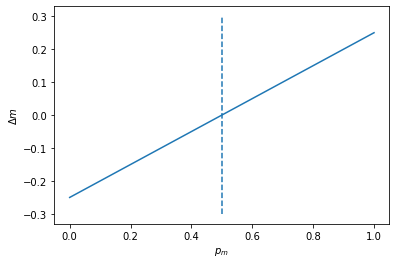

In [9]:
def delta_m(p_m, p_i, m):
    return m * (p_m - p_i)

x = np.linspace(0, 1, 100)
p_m = 0.5
p_i = 0.5
plt.plot(x, delta_m(x, p_m, p_i))
plt.vlines(p_i,-0.3, 0.3, linestyles='dashed')
plt.ylabel('$\Delta m$')
plt.xlabel('$p_m$')

the dotted line here represents the frequency of the island population. Ask yourself, why does 
$\Delta_{m}p_{island} = 0$ at that point? 

## Non-random mating

When individuals do not mate randomly, the assumptions of the Hardy-Weinberg
law are no longer met. A potent force that leads to non-random mating is population
subdivision, where for instance individuals in certain parts of the range
are more likely to mate with one another than they are with individuals that 
are far away or in a separate patch connected via migration. 

Let's motivate this with an example simulation from SLiM, that's a spin on
one we looked at on the first day.


In [10]:
%%slim_stats_reps_rstack 10 --out subdivision
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(0);
    suppressWarnings(T);
}

// create 2 populations of 50 individuals
1 {
    sim.addSubpop("p1", 50);
    sim.addSubpop("p2", 50);
    // sample 50 haploid genomes from the first population
    target = sample(p1.genomes, 50);
    // add a mutation to those genomes
    target.addNewMutation(m1,0, 0);
    //print header for the output
    cat("generation,p,x11,x12,x22\\n");
}
1:300 late(){
    inds1 = p1.sampleIndividuals(50);
    inds2 = p2.sampleIndividuals(50);
    inds = c(inds1, inds2);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs1 = sim.mutationFrequencies(p1);
    freqs2 = sim.mutationFrequencies(p2);
    freqs = freqs1 + freqs2;
    if (length(freqs) > 0.0)
        catn(sim.generation + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


Text(0, 0.5, 'genotype frequency')

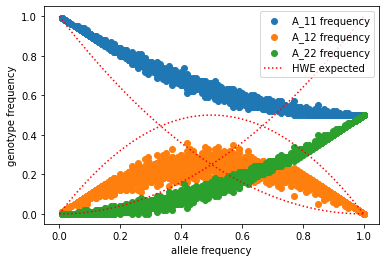

In [15]:
def hwe(p):
    return np.array([p**2, 2 * p * (1 - p), (1 - p)**2])

#run that function for 100 pts between (0,1)
expected = hwe(np.linspace(0,1,100))

#plot simulated
plt.scatter(subdivision.p, subdivision.x11, label="A_11 frequency")
plt.scatter(subdivision.p, subdivision.x12, label="A_12 frequency")
plt.scatter(subdivision.p, subdivision.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

So we can see in this example of two, subdivided populations which don't share migrants that we
are deviating sharply from our Hardy Weinberg expectations. In this specific case you might notice
that there are *too few* heterozygotes relative to our expectations from Hardy Weinberg. Let's 
model this.

## Generalized Hardy-Weinberg


  | Genotype:             | $A_1A_1$ | $A_1A_2$ | $A_2A_2$ |
  |-----------------------|--------------------|----------|----------|
  | H-W Frequency:        |  $p^2(1-F) + pF$   |  $2pq(1-F)$   |  $q^2(1-F) + qF$   |

  We've introduced a new variable here, $F$, which the deviations from the expected frequencies.
  If $F=0$ we are back to our expected HW values. If $0 < F \leq 1$ then there is an excess of homozygotes 
  relative to expectations, if $F < 0$ there is an excess of heterozygotes. 

Next lets look a bit more closely at a flavor of $F$ that we use in the particular case of subdivision
that we are simulating above. Let's call that $Fst$. Next imagine a species arranged as above
in two discrete subpopulations that we could call subpop1 and subpop2. Next let's imagine that the
current allele and genotype frequencies in each of my subpops is as follows:

| Genotype:             | $A_1$ | $A_1A_1$ | $A_1A_2$ | $A_2A_2$ |
  |---------------------|--|--------------------|----------|----------|
  | Subpop1 Frequency:   |  0.25 | 0.0625   |  0.375   |   0.5625  |
  | Subpop2 Frequency:   |  0.75 | 0.5625   |  0.375   |   0.0625  |
  | Species-wide Frequency:   |  0.5 | 0.3125   |  0.375   |   0.3125 |
  | HWE Frequency:   |  0.5 | 0.25   |  0.5   |   0.25 |

here is species-wide frequency is simple the average of the two subpopulations, assuming 
they are of equal size. Here, even though each subpopulation has HW expected proportions
of genotype frequencies, the species as a whole does not. In fact there are
too few heterozygotes relative to our expectations. Let's measure this with $Fst$, 
we say

$$\begin{aligned}
2pq(1-F_{st}) & = 0.375 \\
(1-F_{st})  & = 0.375 / 0.5 \\
F_{st} &= 0.25
\end{aligned}$$ 

In general, populations that have insufficient migration between them to homogenize 
allele frequencies across the landscape with show positive $F_{st}$ like this in pooled
samples. This deficiency of heterozygotes in cryptically sampled subpopulations is
sometimes called the Wahlund effect.

### SLiM simulations with migration

Okay let's modify our simulations above to include migration between populations. Let's start with little migration
and then increase it back in.

In [32]:
%%slim_stats_reps_rstack 10 --out subdivision
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(0);
    suppressWarnings(T);
}

// create 2 populations of 50 individuals
1 {
    sim.addSubpop("p1", 50);
    sim.addSubpop("p2", 50);
    // add migration between the two populations
    p1.setMigrationRates(p2, 0.001);
    p2.setMigrationRates(p1, 0.001);

    // sample 50 haploid genomes from the first population
    target = sample(p1.genomes, 50);
    // add a mutation to those genomes
    target.addNewMutation(m1,0, 0);
    //print header for the output
    cat("generation,p,x11,x12,x22\\n");
}
1:300 late(){
    inds1 = p1.sampleIndividuals(50);
    inds2 = p2.sampleIndividuals(50);
    inds = c(inds1, inds2);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs1 = sim.mutationFrequencies(p1);
    freqs2 = sim.mutationFrequencies(p2);
    freqs = (freqs1 + freqs2) / 2;
    if (length(freqs) > 0.0)
        catn(sim.generation + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


Text(0, 0.5, 'genotype frequency')

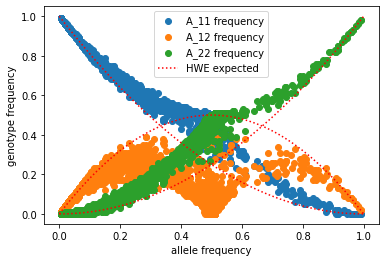

In [33]:
#plot simulated
plt.scatter(subdivision.p, subdivision.x11, label="A_11 frequency")
plt.scatter(subdivision.p, subdivision.x12, label="A_12 frequency")
plt.scatter(subdivision.p, subdivision.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

what do you notice here? what is the pattern?